# Building our Neural Network

### Introduction

In the last lesson, we saw some of the data that neural networks could interpret, and explored our Fashion dataset.  In this lesson, we'll work with that dataset again, this time feeding it into a neural network, and then using the neural network to identify some images. 

### Getting our Data

Once again, we'll need to download our data, which we can do so with the following line of code:

In [2]:
import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

And then let's make sure we still have some articles of clothing.

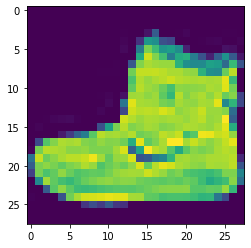

In [3]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])

And our first label is the following.

In [4]:
y_train[0]

9

Ok, let's take a look at what these numbers correspond to make sure this makes sense.

In [5]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

Ok, cool so far so good.  Let's move onto building our neural network.

### Building our Neural Network

To build our neural network, we'll use the Pytorch library.  There's no way we can understand the ins and outs of a neural network just in this lesson.  Instead, let's just see it action for now.

We'll start by importing the Pytorch library, and then can build a neural network class with the following.

> Press `shift + return` on the code below.

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.W1 = nn.Linear(28*28, 64)
        self.W2 = nn.Linear(64, 64)
        self.W3 = nn.Linear(64, 64)
        self.W4 = nn.Linear(64, 10)
        
    def forward(self, X):
        A1 = torch.sigmoid(self.W1(X))
        A2 = torch.sigmoid(self.W2(A1))
        A3 = torch.sigmoid(self.W3(A2))
        Z4 = self.W4(A3)
        return Z4

So above, we defined a *class* that creates neural networks.  A **class** is a programming concept.  If you're not familiar with term, just know that in the lines above we essentially created a factory that now can produce neural networks for us.  Want to build a neural network?  We just need to call on our factory.

In [82]:
net = Net()
net

Net(
  (W1): Linear(in_features=784, out_features=64, bias=True)
  (W2): Linear(in_features=64, out_features=64, bias=True)
  (W3): Linear(in_features=64, out_features=64, bias=True)
  (W4): Linear(in_features=64, out_features=10, bias=True)
)

Ok, so now that we created our class for building neural networks, and created a neural network itself, let's start training the neural network.

### Our Prediction Function

Now remember that *training* our neural network means that we'll feed our neural network our input data, and the corresponding labels.  This should make sense.  When we called `net = Net()`, we just built a neural network fresh out of the factory.  So while it has the capacity to learn how to identify images -- it hasn't undergone it's training process yet.

If we fed it a picture, it would just make a wild prediction as to what that actual image was.  Let's see that.

Ok, now before we feed our training data into the neural network, we'll first need change it up a little.  Currently, our training data is a numpy array.

In [83]:
type(X_train)

numpy.ndarray

We'll need to convert this into Pytorch's equivalent data structure, and make sure that every item is a float.

> We do so with the following.

In [84]:
X_train_tensor = torch.tensor(X_train).float()

And then we'll need to select our first image, and change it from a grid of 28x28 pixels into one long list of $28*28=784$ pixels. 

In [85]:
first_obs = X_train_tensor[0].view(-1, 784)

We'll discuss the `view` function in more detail later on.  But notice that our first observation has been changed to a list.

In [86]:
first_obs[0][:3]

tensor([0., 0., 0.])

In [87]:
first_obs.shape

torch.Size([1, 784])

Ok, now we also will need to convert the labels in the `y_train` variable from an array to a tensor, and to a `long` datatype (which is essentially an integer).

In [88]:
y_train_tensor = torch.tensor(y_train).long().view(-1, 1)

In [89]:
y_train_tensor.dtype

torch.int64

Ok, and we can make a prediction with that first observation.

In [90]:
pred = net(first_obs)
pred

tensor([[-0.0601, -0.1083,  0.1887,  0.3067,  0.5202,  0.0994, -0.5060,  0.0025,
          0.1033,  0.1399]], grad_fn=<AddmmBackward>)

### Understanding the Prediction

Ok, now let's spend some more time interpreting the prediction above.  It may be difficult to understand how the list of numbers above is somehow our neural network predicting what article of clothing was passed through.  What's happening is our neural net is returning 10 numbers one for each of the different fashion labels.

In [91]:
fashion_mnist_labels

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

It returns 10 different numbers to indicate the likelihood that the photo matches any particular label.

In [92]:
F.softmax(pred, dim = 1)

tensor([[0.0852, 0.0812, 0.1092, 0.1229, 0.1522, 0.0999, 0.0545, 0.0907, 0.1003,
         0.1040]], grad_fn=<SoftmaxBackward>)

So above, our neural network is saying that there is roughly a $8.5%$ likelihood of the picture being a T-shirt, an $8.1%$ likelihood of being a trouser, and so on.

If we want to what the neural network thinks is most likely, it's simply the index of with the largest number.  We can get pytorch to tell us which value this is, like so.

In [93]:
torch.argmax(pred)

tensor(4)

So we can see that our neural network predicts that the first image is what's at image 4 -- or a coat.  In future lessons, we'll better understand this prediction function.  For now, let's move onto training the neural network.

### Training a Neural Network

So we just made a prediction as to what an image is, with an untrained neural network -- that is, a neural network which has not seen a bunch of images and the corresponding labels.  Now it's time to see how our neural network does when we train it.

Now in training we'll do the following.  We'll take our set of images, and for each image, we'll input it into our neural network, have the neural network make a prediction, and then update the neural network based on how off the prediction was.  So if the neural network said there was a $.05$ percent chance of the picture being a hat, but the picture was in fact a hat -- the neural network will be updated a lot, and if it predicted a $.95$ percent chance of our hat being a hat, then we would not update our neural network so much.

What does it mean to update a neural network?  Well let's take a look at our neural network again.

In [94]:
net

Net(
  (W1): Linear(in_features=784, out_features=64, bias=True)
  (W2): Linear(in_features=64, out_features=64, bias=True)
  (W3): Linear(in_features=64, out_features=64, bias=True)
  (W4): Linear(in_features=64, out_features=10, bias=True)
)

Each one of those `W's` represents a grid of numbers.  Let's see one.

In [95]:
net.W3._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[ 0.0259, -0.0138, -0.0259,  ..., -0.0757, -0.0621, -0.0298],
                      [ 0.1063,  0.0534, -0.0855,  ..., -0.0165, -0.0313, -0.0833],
                      [ 0.1078,  0.0445,  0.0239,  ..., -0.0503,  0.0975, -0.0178],
                      ...,
                      [ 0.1124,  0.0989, -0.0902,  ..., -0.0939, -0.0652,  0.1107],
                      [ 0.1120, -0.0405,  0.0659,  ..., -0.0038, -0.0218, -0.0882],
                      [ 0.1226,  0.0628, -0.0597,  ..., -0.0875,  0.0712,  0.1169]],
                     requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([-0.0495,  0.0637, -0.1004, -0.0250, -0.0909,  0.1096,  0.0405,  0.0485,
                       0.0361, -0.1112,  0.0071,  0.0476,  0.1005,  0.0198, -0.0114,  0.0470,
                      -0.0566, -0.0448,  0.0945, -0.0279, -0.0823,  0.1084,  0.1233,  0.1245,
                      -0.

That's a lot of numbers.  

> And remember, these are just the numbers that consist of one of those `W's`.  There are four of them.

Depending on how far off the neural network's ultimate prediction is, those numbers will be updated with each prediction the neural network sees.  

It takes a little bit of setup to go through this, but still let's see it in action.

> We use something called cross entropy loss, and an optimizer -- both oof which we'll learn more about later.

In [96]:
x_loss = nn.CrossEntropyLoss()
x_loss
# CrossEntropyLoss()

import torch.optim as optim
adam = optim.Adam(net.parameters(), lr=0.005)

And then if we pass through the neural network's *prediction*, and the corresponding label, we can see how far off we were.

In [97]:
pred = net(first_obs)
pred

first_label = y_train_tensor[0]
first_label

loss = x_loss(pred, first_label)
loss

tensor(2.2632, grad_fn=<NllLossBackward>)

Then we can calculate how to update our neural network, and finally, make the update with the `step` function.

In [98]:
loss.backward()
adam.step()

With that our neural network has been updated, just a little bit, based on it's poor prediction of the first image.  Let's see this.

> Notice that the first number was updated from $.0259$ to $.03$

In [100]:
net.W3._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[ 0.0309, -0.0088, -0.0209,  ..., -0.0707, -0.0571, -0.0248],
                      [ 0.1013,  0.0484, -0.0905,  ..., -0.0215, -0.0363, -0.0883],
                      [ 0.1128,  0.0495,  0.0289,  ..., -0.0453,  0.1025, -0.0128],
                      ...,
                      [ 0.1174,  0.1039, -0.0852,  ..., -0.0889, -0.0602,  0.1157],
                      [ 0.1170, -0.0355,  0.0709,  ...,  0.0012, -0.0168, -0.0832],
                      [ 0.1276,  0.0678, -0.0547,  ..., -0.0825,  0.0762,  0.1219]],
                     requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([-0.0445,  0.0587, -0.0954, -0.0200, -0.0859,  0.1046,  0.0355,  0.0435,
                       0.0411, -0.1062,  0.0021,  0.0426,  0.1055,  0.0148, -0.0164,  0.0420,
                      -0.0616, -0.0398,  0.0995, -0.0329, -0.0773,  0.1134,  0.1283,  0.1295,
                      -0.

### Putting it all together

Ok, so now we just loop through all of our images, and for each one, ask our neural network to make a prediction, calculate how far off the neural network was, and how to update the neural network, and then make the update.  

Doing this 70,000 times will take some time (about 10 minutes).  And to keep even that efficient, you'll first need to go to the menu bar, followed by `runtime` and then `change runtime type`.

> <img src="./change_runtime_type.png" width="30%">

Click on that, and then change the runtime type to GPU.

> <img src="./to_gpu.png" width="40%">

With that done, it's time to go train our neural network on the 70,000 images.

In [106]:
for epoch in range(3):
    for (x, y) in zip(x_train_tensor, y_train_tensor):
        net.zero_grad()  
        X_reshaped = x.view(-1,28*28)
        prediction_batch = net(X_reshaped)
        loss = x_loss(prediction_batch, y) 
        loss.backward() 
        adam.step()
    print(loss)

tensor(1.0554, grad_fn=<NllLossBackward>)
tensor(0.1444, grad_fn=<NllLossBackward>)
tensor(0.7173, grad_fn=<NllLossBackward>)
tensor(0.1364, grad_fn=<NllLossBackward>)
tensor(0.0828, grad_fn=<NllLossBackward>)
tensor(2.5173, grad_fn=<NllLossBackward>)
tensor(0.1435, grad_fn=<NllLossBackward>)
tensor(0.1413, grad_fn=<NllLossBackward>)


### Evaluating our Neural Network

Now let's get a sense of how our neural network performed.  First make  predictions on the first twenty observations in the testset.

In [125]:
x_test = torch.tensor(x_test).float()

In [126]:
predictions_test = net(x_test.view(-1, 28*28).float())

In [127]:
torch.exp(predictions_test[:1])

# tensor([[4.4961e-08, 1.2412e-05, 4.5766e-09, 9.3961e-07, 1.2311e-06, 9.5997e-04,
#          4.3604e-08, 4.5264e-03, 2.0135e-05, 9.9448e-01]],
#        grad_fn=<ExpBackward>)

tensor([[1.8848e-12, 2.2202e-16, 4.5645e-16, 1.6148e-15, 1.4248e-14, 4.9672e-02,
         3.9909e-13, 7.0305e-01, 8.7145e-04, 2.4641e-01]],
       grad_fn=<ExpBackward>)

In [128]:
hard_predictions = torch.argmax(predictions_test, axis = 1)

In [129]:
hard_predictions[:10]

tensor([7, 2, 1, 1, 2, 1, 2, 2, 8, 7])

In [130]:
y_test[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

Looking good so far.  Next, check the accuracy of our neural network on our testset.

In [133]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, hard_predictions)

# 0.8303

0.7022

So we can see that our neural network identifies $.70$ of the data correctly.  Perhaps not perfect, but not too bad either.

### Summary

In this lesson, we trained a neural network in Pytorch.  Nice work!!

### Resources

[Colab Deeep Learning](https://colab.research.google.com/github/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb#scrollTo=d44TznbgZZgm)

[Log Softmax](https://stats.stackexchange.com/questions/436766/cross-entropy-with-log-softmax-activation)